# Qualitative Error analysis

In [2]:
import numpy as np
import sys
sys.path.append('src/')
import torch
from time import time
from torch.autograd import Variable
from data.dataset_utils import TilesClassificationDataLoader
#from model_architectures.googlenet.googtilenet import make_googtilenet
from model_architectures.googlenet.googtilenet_v3 import make_googtilenet
from utils import get_timestr
from tqdm import tqdm 

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

cuda = torch.cuda.is_available()
in_channels = 4
z_dim = 512
net = make_googtilenet(in_channels=in_channels, z_dim=z_dim)
if cuda: 
    net = net.cuda()

# Load parameters
checkpoint = torch.load("src/models/GoogTiLeNet_v3_epoch3.ckpt")
net.load_state_dict(checkpoint)
net.eval()

n_tiles = 1000
test_fraction = 0.2
random_state = 42 # so that train test splits of tiles and their embeddings are same
X = np.zeros((n_tiles, z_dim))
y = np.zeros(n_tiles)

dataloader = TilesClassificationDataLoader(batch_size=1, num_tiles_requested = n_tiles)

print(f'Begin at {get_timestr()}................')
for i, sample in enumerate(tqdm(dataloader)):
    tile = sample['tile']
    tile = torch.squeeze(tile, dim=0)
    label = sample['label']
    y[i] = label
    tile = Variable(tile)
    if cuda: 
        tile = tile.cuda()
    z = net.forward(tile)
    if cuda: z = z.cpu()
    z = z.data.numpy()

    z.squeeze(0)
    X[i, :] = z

print(f'{get_timestr()} | finished embedding')
y = LabelEncoder().fit_transform(y)
# print(set(y))

n_trials = 1
accs = np.zeros((n_trials,))
for i in range(n_trials):
    # Splitting data and training RF classifer
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_fraction, random_state=random_state)
    tiles_tr, tiles_te = train_test_split(dataloader.dataset, test_size=test_fraction, random_state=random_state)

    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr)
    accs[i] = rf.score(X_te, y_te)
    print(f'Trial {i} has accuracy {accs[i]}')
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))

print(f'End at {get_timestr()}................')

Begin at 07:28 AM, June 08................


100%|██████████| 1000/1000 [00:14<00:00, 70.20it/s]


07:28 AM, June 08 | finished embedding
Trial 0 has accuracy 0.465
Mean accuracy: 0.4650
Standard deviation: 0.0000
End at 07:28 AM, June 08................


In [4]:
from data.dataset_utils import get_label
from collections import Counter
from utils import viz

y_est = rf.predict(X_te)#.shape
y_est_str = [get_label(y) for y in y_est]
y_te_str = [get_label(y) for y in y_te]
print('Predicted counts', Counter(y_est_str))
print('True counts', Counter(y_te_str))


# Pair the true and estimated labels
label_pairs = zip(y_te_str, y_est_str)

# Count the occurrences of each label pair
label_counts = Counter(label_pairs)

# Sort the label counts in descending order
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Print the ranked label pairs and their frequencies
print("\nMost common (true, predicted) pairs")
for label_pair, frequency in sorted_labels:
    print(f"True: {label_pair[0]}, Predicted: {label_pair[1]}, Frequency: {frequency}")


Predicted counts Counter({'Safflower': 92, 'Alfalfa': 38, 'Sod/Grass Seed': 27, 'Onions': 7, 'Other Crops': 7, 'Oats': 6, 'Watermelons': 6, 'Peas': 4, 'Spring Wheat': 3, 'Citrus': 3, 'Dry Beans': 2, 'Corn': 2, 'Sweet Corn': 1, 'Rye': 1, 'Cherries': 1})
True counts Counter({'Safflower': 67, 'Alfalfa': 39, 'Sod/Grass Seed': 23, 'Other Crops': 18, 'Spring Wheat': 9, 'Oats': 7, 'Peas': 7, 'Onions': 5, 'Watermelons': 5, 'Citrus': 4, 'Rye': 3, 'Corn': 3, 'Sweet Corn': 2, 'Dry Beans': 2, 'Durum Wheat': 1, 'Winter Wheat': 1, 'Pecans': 1, 'Sorghum': 1, 'Grapes': 1, 'Cotton': 1})

Most common (true, predicted) pairs
True: Safflower, Predicted: Safflower, Frequency: 50
True: Alfalfa, Predicted: Alfalfa, Frequency: 21
True: Sod/Grass Seed, Predicted: Sod/Grass Seed, Frequency: 17
True: Alfalfa, Predicted: Safflower, Frequency: 12
True: Other Crops, Predicted: Safflower, Frequency: 10
True: Safflower, Predicted: Alfalfa, Frequency: 9
True: Oats, Predicted: Safflower, Frequency: 3
True: Peas, Predic

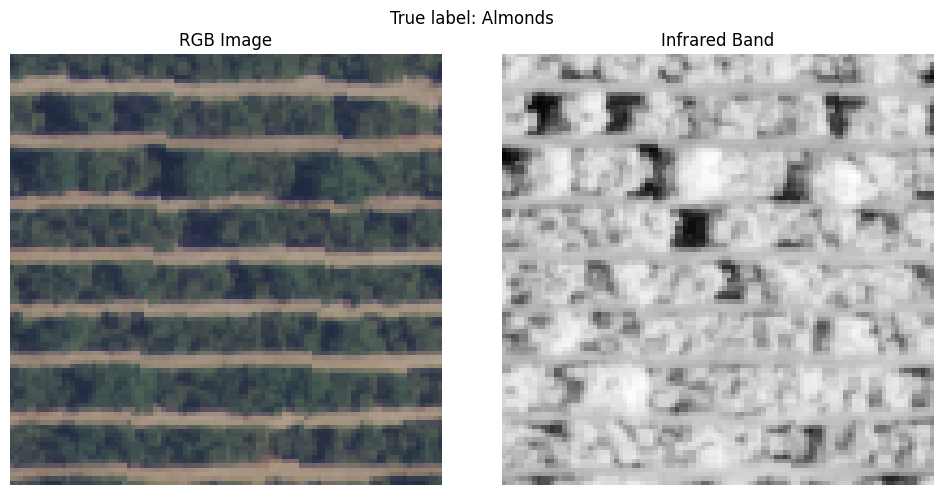

In [62]:
for i in range(len(y_te_str)):
    if y_te_str[i]=='Alfalfa' and y_est_str[i]=='Safflower':
        viz(tiles_te[i])
        break

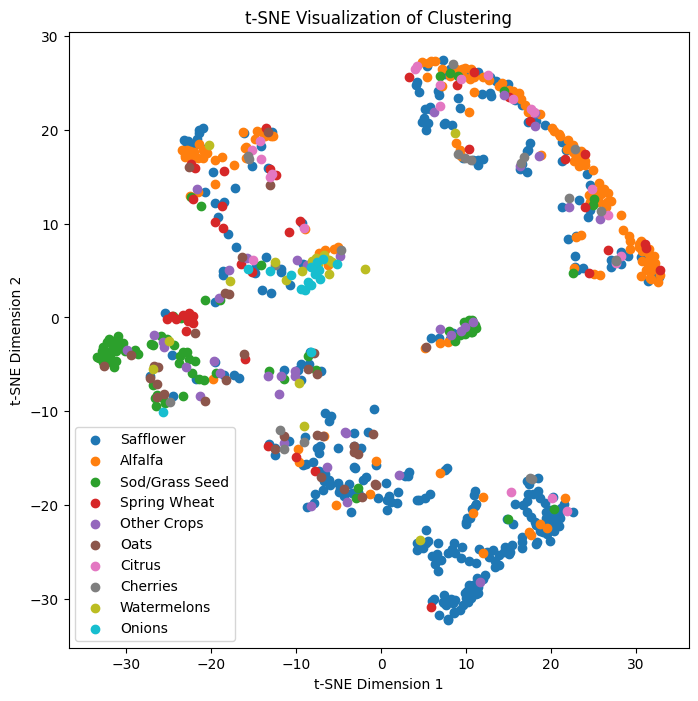

In [3]:
from utils import viz_tsne
viz_tsne(X_tr, y_tr)

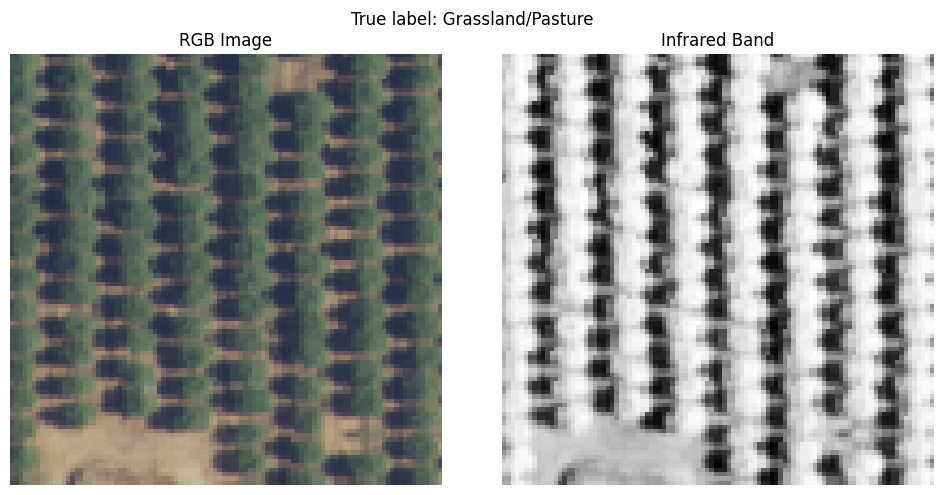

In [2]:
# Creation of labels.csv
# data_dir = '/home/ubuntu/cs231n_project/cs231n_project/land_cover_representation/'
# metadata = pd.read_csv(os.path.join(data_dir,'metadata.csv'))
# labels = metadata[['y', 'land_cover']].drop_duplicates().sort_values('y')
# labels.to_csv('src/data/labels.csv', index=False)

z = dataloader.dataset[0]

from utils import viz
viz(z)


# Fix nan losses

In [4]:
from torch.utils.data import Dataset, DataLoader
import sys
import os
import torch
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
import time
from tqdm import tqdm 

sys.path.append('src/')
from data.dataset_utils import TripletDataLoader
#from model_architectures.googlenet.googtilenet import make_googtilenet
from model_architectures.googlenet.googtilenet_v3 import make_googtilenet
from training import train_triplet_epoch

img_type = 'naip'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = torch.cuda.is_available()
in_channels = 4
z_dim = 512

def prep_triplets(triplets, cuda):
    """
    Takes a batch of triplets and converts them into Pytorch variables 
    and puts them on GPU if available.
    """
    a, n, d = (Variable(triplets['anchor']), Variable(triplets['neighbor']), Variable(triplets['distant']))
    if cuda:
    	a, n, d = (a.cuda(), n.cuda(), d.cuda())
    return (a, n, d)


In [5]:
net = make_googtilenet(in_channels=in_channels, z_dim=z_dim)
if cuda: net.cuda()
net.train()

# Load parameters
epoch_start = 3
model_fn = f'src/models/GoogTiLeNet_v3_epoch{epoch_start}.ckpt'
checkpoint = torch.load(model_fn)
net.load_state_dict(checkpoint)
net.train()

print('GoogTiLeNet set up complete.')

lr = 1e-3
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1.01)
scheduler = None
# scheduler = MultiStepLR(optimizer, 
#                         milestones=[3, 4], # List of epoch indices
#                         gamma =0.1)

print('Optimizer set up complete.')

dataloader = TripletDataLoader(img_type, batch_size=64)

print('Dataset set up.')

margin = 10
l2 = 0.01
max_grad_norm = 1.0
print_every=1

net.train()
sum_loss, sum_l_n, sum_l_d, sum_l_nd = (0, 0, 0, 0)
n_train, n_batches = len(dataloader.dataset), len(dataloader)
print_sum_loss = 0
verbose=False
for idx, triplets in enumerate(tqdm(dataloader, desc="training loop within epoch")):
    p, n, d = prep_triplets(triplets, cuda)
    optimizer.zero_grad()
    #verbose = idx==23
    loss, l_n, l_d, l_nd = net.loss(p, n, d, margin=margin, l2=l2, verbose=verbose)
    
    if torch.isnan(loss) or torch.isinf(loss):
            for param_group in optimizer.param_groups:
                learning_rate = param_group['lr']
                print("Learning rate:", learning_rate)
            print(f"Stopping at epoch {epoch_start+1} id {idx} because of nan loss")
            raise 
    loss.backward()

    # Track max and min gradients with layer names
    # max_grad = (-float('inf'), None, None)  # (grad_value, layer_name, parameter_name)
    # min_grad = (float('inf'), None, None)  # (grad_value, layer_name, parameter_name)
    # for name, param in net.named_parameters():
    #     if 'weight' in name and 'Aux' not in name:
    #         grad = param.grad
    #         max_grad = max(max_grad, (grad.abs().max().item(), name, param))
    #         min_grad = min(min_grad, (grad.abs().min().item(), name, param))
    
    # print("Max gradient layer:", max_grad[1])
    # #print("Parameter:", max_grad[2])
    # print("Max gradient value:", max_grad[0])
    
    # print("Min gradient layer:", min_grad[1])
    # #print("Parameter:", min_grad[2])
    # print("Min gradient value:", min_grad[0])

    if max_grad_norm:
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
    optimizer.step()
    if scheduler:
        scheduler.step(loss)

    sum_loss += loss.data
    # sum_l_n += l_n.data
    # sum_l_d += l_d.data
    # sum_l_nd += l_nd.data
    if (idx + 1) * dataloader.batch_size % print_every == 0:
            print_avg_loss = (sum_loss - print_sum_loss) / (
                print_every / dataloader.batch_size)
            print('[{}/{} ], avg loss: {:0.4f}'.format(
                    (idx + 1) * dataloader.batch_size, n_train,
                loss.data))
            print_sum_loss = sum_loss
# avg_loss = sum_loss / n_batches
# avg_l_n = sum_l_n / n_batches
# avg_l_d = sum_l_d / n_batches
# avg_l_nd = sum_l_nd / n_batches
# print('Finished epoch {}: {:0.3f}s'.format(epoch, time()-t0))
# print('  Average loss: {:0.4f}'.format(avg_loss))
# print('  Average l_n: {:0.4f}'.format(avg_l_n))
# print('  Average l_d: {:0.4f}'.format(avg_l_d))
# print('  Average l_nd: {:0.4f}\n'.format(avg_l_nd))
# return (avg_loss, avg_l_n, avg_l_d, avg_l_nd)

GoogTiLeNet set up complete.
Optimizer set up complete.
73894
Dataset set up.


training loop within epoch:   0%|          | 1/1155 [00:00<18:09,  1.06it/s]

[64/73894 ], avg loss: 4.4241


training loop within epoch:   0%|          | 2/1155 [00:01<10:38,  1.81it/s]

[128/73894 ], avg loss: 4.8368


training loop within epoch:   0%|          | 3/1155 [00:01<08:14,  2.33it/s]

[192/73894 ], avg loss: 4.5915


training loop within epoch:   0%|          | 4/1155 [00:01<07:07,  2.70it/s]

[256/73894 ], avg loss: 4.4526


training loop within epoch:   0%|          | 5/1155 [00:02<06:31,  2.94it/s]

[320/73894 ], avg loss: 4.7403


training loop within epoch:   1%|          | 6/1155 [00:02<06:07,  3.12it/s]

[384/73894 ], avg loss: 6.8817


training loop within epoch:   1%|          | 7/1155 [00:02<05:53,  3.25it/s]

[448/73894 ], avg loss: 5.5950


training loop within epoch:   1%|          | 8/1155 [00:02<05:43,  3.34it/s]

[512/73894 ], avg loss: 6.6018


training loop within epoch:   1%|          | 9/1155 [00:03<05:36,  3.41it/s]

[576/73894 ], avg loss: 6.6192


training loop within epoch:   1%|          | 10/1155 [00:03<05:31,  3.45it/s]

[640/73894 ], avg loss: 7.2465


training loop within epoch:   1%|          | 11/1155 [00:03<05:27,  3.49it/s]

[704/73894 ], avg loss: 7.9526


training loop within epoch:   1%|          | 12/1155 [00:04<05:25,  3.51it/s]

[768/73894 ], avg loss: 7.6853


training loop within epoch:   1%|          | 13/1155 [00:04<05:24,  3.52it/s]

[832/73894 ], avg loss: 8.0952


training loop within epoch:   1%|          | 14/1155 [00:04<05:22,  3.54it/s]

[896/73894 ], avg loss: 8.3073


training loop within epoch:   1%|▏         | 15/1155 [00:04<05:21,  3.55it/s]

[960/73894 ], avg loss: 8.1873


training loop within epoch:   1%|▏         | 16/1155 [00:05<05:20,  3.55it/s]

[1024/73894 ], avg loss: 8.5784


training loop within epoch:   1%|▏         | 17/1155 [00:05<05:19,  3.56it/s]

[1088/73894 ], avg loss: 8.8355


training loop within epoch:   2%|▏         | 18/1155 [00:05<05:19,  3.56it/s]

[1152/73894 ], avg loss: 8.9679


training loop within epoch:   2%|▏         | 19/1155 [00:06<05:18,  3.56it/s]

[1216/73894 ], avg loss: 9.2752


training loop within epoch:   2%|▏         | 20/1155 [00:06<05:18,  3.56it/s]

[1280/73894 ], avg loss: 9.1433


training loop within epoch:   2%|▏         | 21/1155 [00:06<05:18,  3.56it/s]

[1344/73894 ], avg loss: 9.1336


training loop within epoch:   2%|▏         | 22/1155 [00:06<05:18,  3.56it/s]

[1408/73894 ], avg loss: 9.2613


training loop within epoch:   2%|▏         | 23/1155 [00:07<06:00,  3.14it/s]

[1472/73894 ], avg loss: 9.3298
Learning rate: 0.001
Stopping at epoch 4 id 23 because of nan loss


RuntimeError: No active exception to reraise